In [ ]:
"""
Copyright 2022, The Johns Hopkins University Applied Physics Laboratory LLC
All rights reserved.
Distributed under the terms of the BSD 3-Clause License.

Approved for public release; distribution is unlimited.
This material is based upon work supported by the Defense Advanced Research Projects Agency (DARPA) under Agreement No. HR00112290032.
"""

In [1]:
import os
from pathlib import Path
import pickle
from glob import glob
import json
import numpy as np
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from box_model import box_model

In [13]:
# Load model data
box_sim_data_dir = Path(os.path.join("/home", "chungdw1", "PACMANs", "gan", "tmp", "data"))
exp_name = "anand_sim_all_3c"
box_sim_data_filenames = glob(str(box_sim_data_dir / f"{exp_name}_array*.pkl"))

box_sim_data_keys = ["sample", "labels", "scaler", "last_M_n",
"train_sample", "train_labels", "test_sample", "test_labels"]

data_dict = dict(**{k:[] for k in box_sim_data_keys})
data_dict["scaler"] = None
for fname in box_sim_data_filenames:
	with open(fname, "rb") as f:
		fname_dict = pickle.load(f)
	for k in box_sim_data_keys:
		if k == "scaler":
			data_dict[k] = fname_dict[k]
		else:
			data_dict[k].append(fname_dict[k])

for k in box_sim_data_keys:
	if k != "scaler":
		data_dict[k] = np.concatenate(data_dict[k], axis=0)

In [14]:
# Load config file
cfg_dir = Path(os.path.join("/home", "chungdw1", "PACMANs", "gan", "scripts", "box_configs"))
cfg_path = cfg_dir / f"anand_sim_all_box_cfg.json"

with open(cfg_path, "r") as f:
	cfg = json.load(f)
cfg.keys()

dict_keys(['perturb_vars', 'perturb_min', 'perturb_max', 'n_samples', 'constants_dict'])

In [15]:
# View labels
n_classes = 3
data_labels = data_dict["labels"]
for i in range(n_classes):
    print(f"Number of samples in class {i}: ")
    print(data_labels[data_labels == i].shape[0])
    print()

Number of samples in class 0: 
183719

Number of samples in class 1: 
294365

Number of samples in class 2: 
21916



In [16]:
# Downsample the major classes
samples_per_class = 6734
nonshutoff_idxs = np.argwhere(data_labels == 0).flatten()
shutoff_idxs = np.argwhere(data_labels == 1).flatten()
recovery_idxs = np.argwhere(data_labels == 2).flatten()

new_idxs = np.concatenate(
		[np.random.choice(nonshutoff_idxs, samples_per_class, replace=False),
		np.random.choice(shutoff_idxs, samples_per_class, replace=False),
		np.random.choice(recovery_idxs, samples_per_class, replace=False)
], axis=0)

data_dict["sample"] = data_dict["sample"][new_idxs, :]
data_dict["labels"] = data_dict["labels"][new_idxs]
data_dict["last_M_n"] = data_dict["last_M_n"][new_idxs]

# Redo train, test split
X_train, X_test, y_train, y_test = train_test_split(data_dict["sample"], data_dict["labels"], test_size=0.2, random_state=27)
data_dict["train_sample"] = X_train
data_dict["test_sample"] = X_test
data_dict["train_labels"] = y_train
data_dict["test_labels"] = y_test

Feature distributions


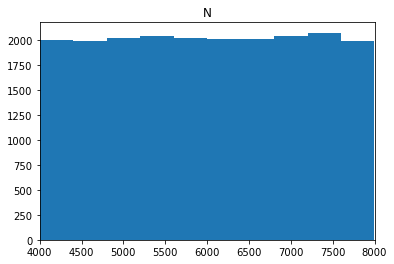

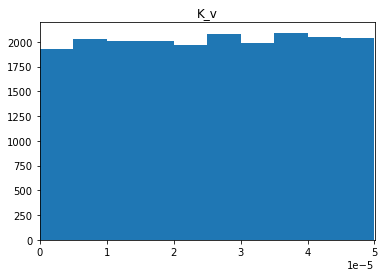

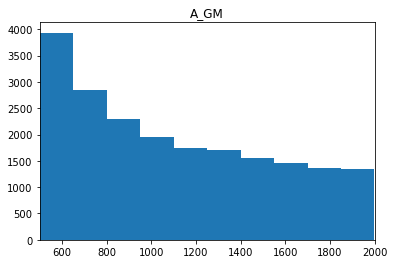

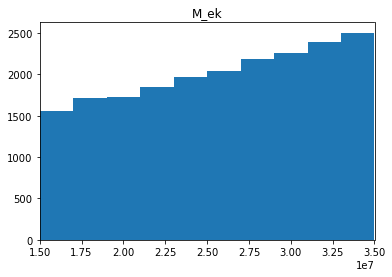

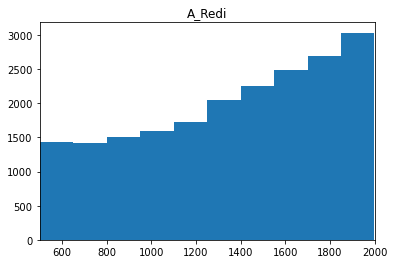

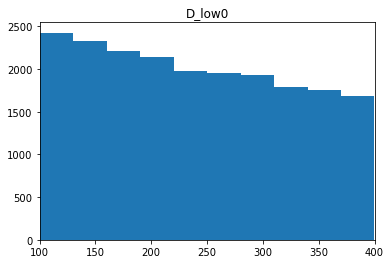

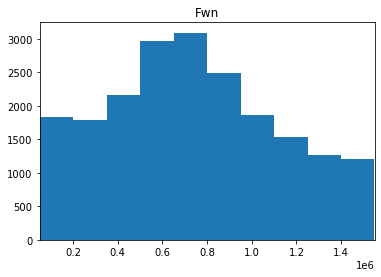

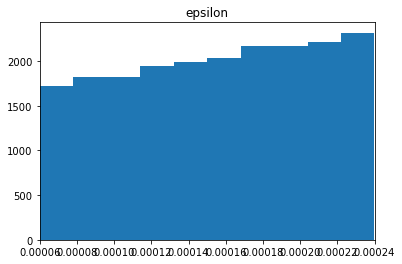

In [17]:
# View features for all classes
data_samples = data_dict["sample"]
n_feats = data_samples.shape[1]

print(f"Feature distributions")
for i in range(n_feats):
    plot_feats = data_samples[:, i]
    plt.hist(plot_feats)
    plt.title(cfg["perturb_vars"][i])
    # if cfg["perturb_vars"][i] == "N":
    #     plt.xlim((cfg["N_values"][0], cfg["N_values"][-1]))
    # elif cfg["perturb_vars"][i] == "time_step_size_in_years":
    #     plt.xlim((cfg["ts_values"][0], cfg["ts_values"][-1]))
    # else:
    #     plt.xlim((cfg["perturb_min"][i],
    #     cfg["perturb_max"][i]))

    plt.xlim((cfg["perturb_min"][i], cfg["perturb_max"][i]))
    plt.show()

Non-shutoff feature distributions
Feature distributions


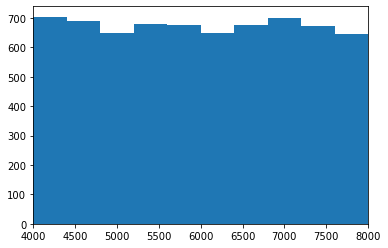

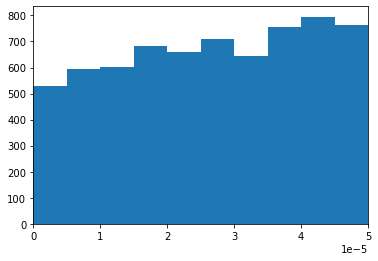

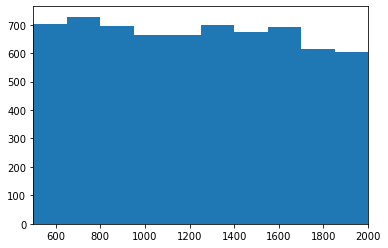

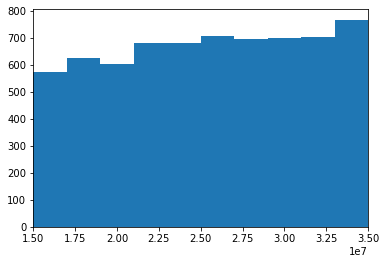

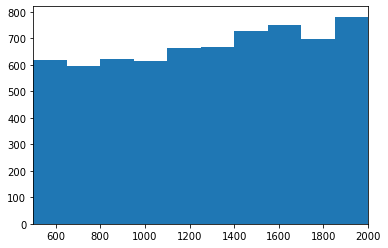

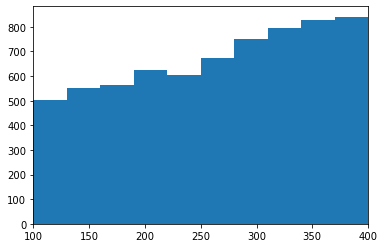

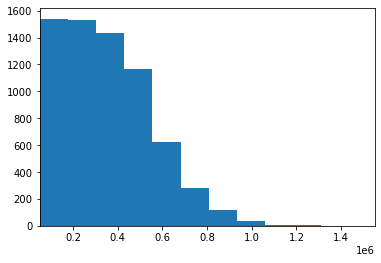

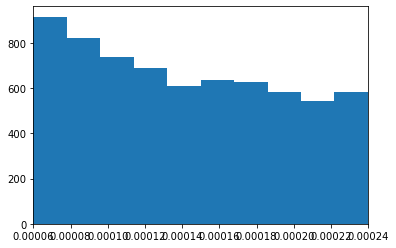

In [18]:
# View features for non-shutoffs
data_samples = data_dict["sample"]
data_labels = data_dict["labels"]
nonshutoff_idxs = np.argwhere(data_labels == 0).flatten()
nonshutoff_samples = data_samples[nonshutoff_idxs]
n_feats = data_samples.shape[1]

print(f"Non-shutoff feature distributions")
print(f"Feature distributions")
for i in range(n_feats):
    plot_feats = nonshutoff_samples[:, i]
    plt.hist(plot_feats)
    # plt.title(cfg["perturb_vars"][i])
    # if cfg["perturb_vars"][i] == "N":
    #     plt.xlim((1000, 8000))
    # elif cfg["perturb_vars"][i] == "time_step_size_in_years":
    #     plt.xlim((0.0, 1.0))
    # else:
    #     plt.xlim((cfg["perturb_min"][i],
    #     cfg["perturb_max"][i]))

    plt.xlim((cfg["perturb_min"][i], cfg["perturb_max"][i]))
    plt.show()

Shutoff feature distributions
Feature distributions


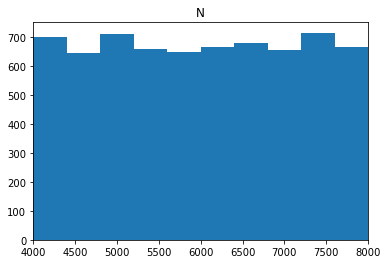

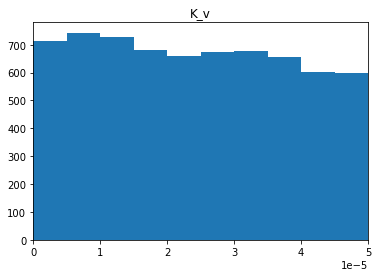

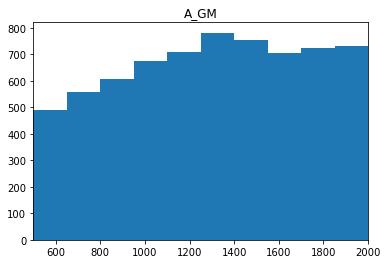

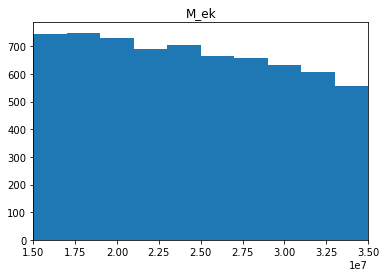

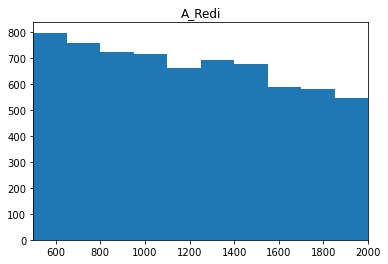

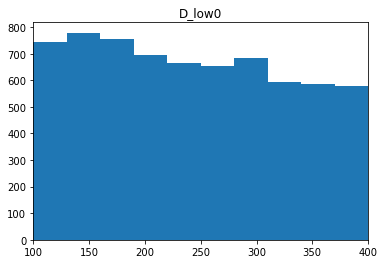

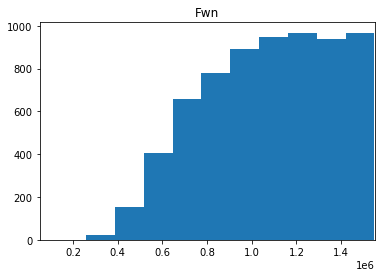

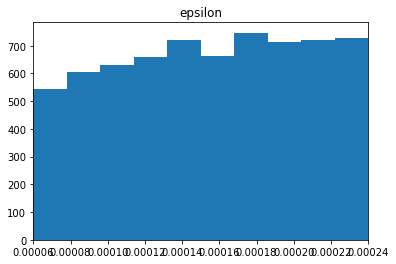

In [19]:
# View features for shutoffs
data_samples = data_dict["sample"]
data_labels = data_dict["labels"]
shutoff_samples = data_samples[data_labels == 1]
n_feats = data_samples.shape[1]

print(f"Shutoff feature distributions")
print(f"Feature distributions")
for i in range(n_feats):
    plot_feats = shutoff_samples[:, i]
    plt.hist(plot_feats)
    plt.title(cfg["perturb_vars"][i])
    # if cfg["perturb_vars"][i] == "N":
    #     plt.xlim((1000, 8000))
    # elif cfg["perturb_vars"][i] == "time_step_size_in_years":
    #     plt.xlim((0.0, 1.0))
    # else:
    #     plt.xlim((cfg["perturb_min"][i],
    #     cfg["perturb_max"][i]))

    plt.xlim((cfg["perturb_min"][i], cfg["perturb_max"][i]))
    plt.show()

Shutoff feature distributions


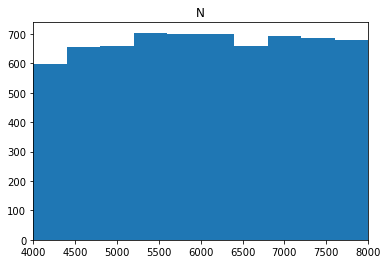

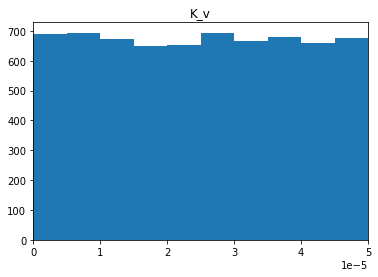

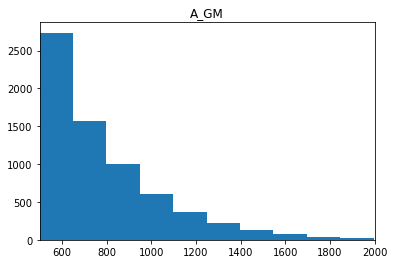

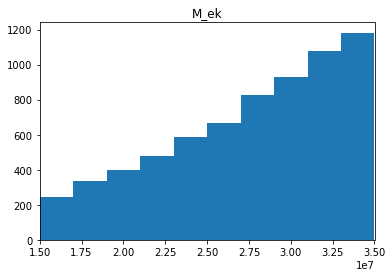

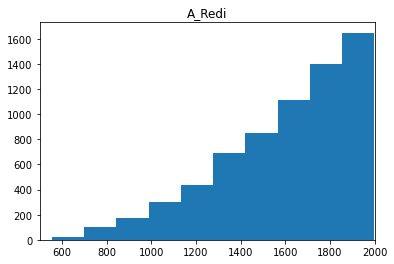

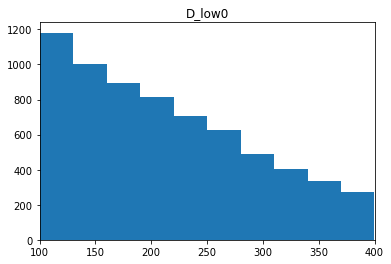

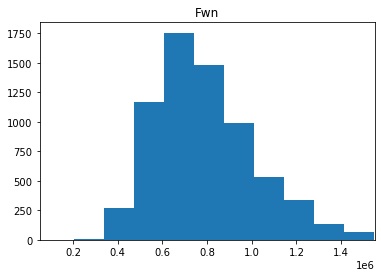

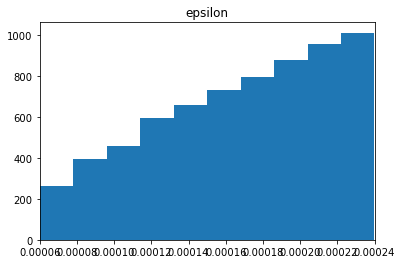

In [20]:
# View features for recoveries
data_samples = data_dict["sample"]
data_labels = data_dict["labels"]
recovery_samples = data_samples[data_labels == 2]
n_feats = data_samples.shape[1]

print(f"Shutoff feature distributions")
for i in range(n_feats):
    plot_feats = recovery_samples[:, i]
    plt.hist(plot_feats)
    plt.title(cfg["perturb_vars"][i])
    # if cfg["perturb_vars"][i] == "N":
    #     plt.xlim((1000, 8000))
    # elif cfg["perturb_vars"][i] == "time_step_size_in_years":
    #     plt.xlim((0.0, 1.0))
    # else:
    #     plt.xlim((cfg["perturb_min"][i],
    #     cfg["perturb_max"][i]))

    plt.xlim((cfg["perturb_min"][i], cfg["perturb_max"][i]))
    plt.show()

In [21]:
# Save new data file
exp_name = "anand_sim_all_3c"
save_filename = str(box_sim_data_dir / f"{exp_name}.pkl")
with open(save_filename, "wb") as f:
	pickle.dump(data_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# Bifurcation plot

In [20]:
Fwn_idx = cfg["perturb_vars"].index("Fwn")
cfg["perturb_vars"], cfg["perturb_min"], cfg["perturb_max"]

(['M_ek', 'D_low0', 'Fwn'],
 [15000000.0, 100.0, 50000.0],
 [35000000.0, 400.0, 1550000.0])

In [21]:
# Sort samples by Fwn (northern freshwater flux)
data_samples_sort_idx = np.argsort(data_samples[:, Fwn_idx])
data_samples_sorted = data_samples[data_samples_sort_idx]

Fwn = data_samples_sorted[:, Fwn_idx]
M_n = data_dict["last_M_n"][data_samples_sort_idx]

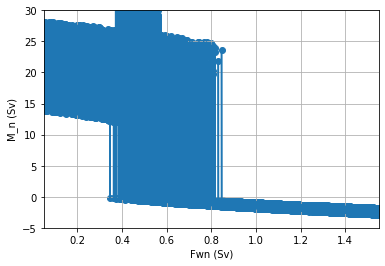

In [23]:
# Plot bifurcation
plt.scatter(Fwn/1e6, M_n/1e6)
plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
# plt.title(f"Sim {sim_idx}")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
plt.grid()
plt.show()

In [12]:
# # original loss -> generator spawn configurations at off-states (i.e. bottom of bifurcation curve)
# -y*log(y_hat)

# # new loss -> generator spawn configurations where discriminator is most uncertain about true state? (i.e. assuming that it's the bifurcation region(s)?)
# -(0.5)*log(y_hat) - (0.5)*log(1-y_hat)

# # n_classes > 2
# -(1/n_classes)*log(y_hat_0) - (1/n_classes)*log(1-y_hat_1) - ...

In [24]:
# Plot non-shutoff solutions
nonshutoff_idxs = np.where(data_labels == 0)
nonshutoff_samples = data_samples[nonshutoff_idxs]

# Sort samples by Fwn (northern freshwater flux)
nonshutoff_samples_sort_idx = np.argsort(nonshutoff_samples[:, Fwn_idx])
nonshutoff_samples_sorted = nonshutoff_samples[nonshutoff_samples_sort_idx]

Fwn = nonshutoff_samples_sorted[:, Fwn_idx]
M_n = data_dict["last_M_n"][nonshutoff_idxs][nonshutoff_samples_sort_idx]

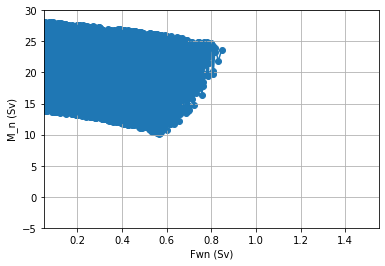

In [26]:
# Plot nonshutoffs
plt.scatter(Fwn/1e6, M_n/1e6)
plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
# plt.title(f"Sim {sim_idx} (Non-shutoffs)")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
plt.grid()

In [27]:
# Plot shutoff solutions
shutoff_idxs = np.where(data_labels == 1)
shutoff_samples = data_samples[shutoff_idxs]

# Sort samples by Fwn (northern freshwater flux)
shutoff_samples_sort_idx = np.argsort(shutoff_samples[:, Fwn_idx])
shutoff_samples_sorted = shutoff_samples[shutoff_samples_sort_idx]

Fwn = shutoff_samples_sorted[:, Fwn_idx]
M_n = data_dict["last_M_n"][shutoff_idxs][shutoff_samples_sort_idx]

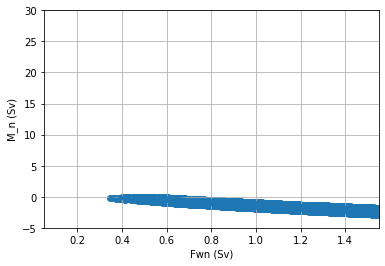

In [28]:
# Plot nonshutoffs
plt.scatter(Fwn/1e6, M_n/1e6)
plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
# plt.title(f"Sim {sim_idx} (Shutoffs)")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
plt.grid()

In [29]:
# Plot recovery solutions
shutoff_idxs = np.where(data_labels == 2)
shutoff_samples = data_samples[shutoff_idxs]

# Sort samples by Fwn (northern freshwater flux)
shutoff_samples_sort_idx = np.argsort(shutoff_samples[:, Fwn_idx])
shutoff_samples_sorted = shutoff_samples[shutoff_samples_sort_idx]

Fwn = shutoff_samples_sorted[:, Fwn_idx]
M_n = data_dict["last_M_n"][shutoff_idxs][shutoff_samples_sort_idx]

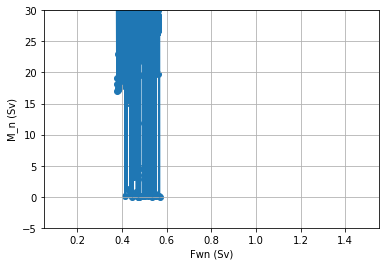

In [30]:
# Plot recoveries
plt.scatter(Fwn/1e6, M_n/1e6)
plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
# plt.title(f"Sim {sim_idx} (Shutoffs)")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
plt.grid()